# Проект - Принятие решений в бизнесе на основе данных

### Описание проекта

#### Постановка задачи

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки. Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

####  Описание последовательности выполнения проекта

**Часть 1 - Приоритизация гипотез**

* Загрузка файлов, их изучение и подготовка к дальнейшему анализу.

* Применение фреймворков `ICE` и `RICE` для приоритизации гипотез.

* Анализ того, какие есть различия в приоритизации между двумя фреймворкам.

**Часть 2 - Анализ A/B-теста**

* Загрузка файлов, их изучение и подготовка к дальнейшему анализу.

* Построение графиков по основным метрикам (кумулятивная выручка, кумулятивный средний чек, кумулятивная конверсия по группам, относительное изменение кумулятивного среднего чека и конверсии группы В к группе А, стоимость заказа)

* Расчёт 95 и 99 перцентилей количества заказов на пользователя, стоимости заказов. Выбор границ для определения аномальных пользователей, а затем их фильтрация.

* Расчёт статистической значимости различий в конверсии и среднем чеке между группами по "сырым", а затем "очищенным" данным. 

* Принятие решения по результатам теста. Возможные исходы - Остановка теста и фиксация победы одной из групп, Остановка теста и фиксация отсутствия различий между группами, Продолжение теста.

#### Описание данных

**Данные для первой части**

`Таблица hypothesis`
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

`Таблица orders`

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

`Таблица visitors`

* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка данных и подготовка их к анализу

### Загрузка и обзор данных из файлов

In [1]:
#Импорт библиотек
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
from IPython.display import display
import warnings
import seaborn as sns
import datetime as dt
import scipy.stats as stats

# отключение уведомлений об ошибке при замене исходного набора данных
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# показ всех колонок датафрейма
pd.options.display.max_columns = None

In [2]:
# загружаем файлы в переменные и выводим на экран
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

# выделим основные таблицы
main_tables = [orders, visitors]

# и выведем первые 5 строк каждой таблицы
for table in main_tables:
    display(table.head())
display(hypothesis)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Посмотрим данные поподробнее

In [3]:
for table in main_tables:
    display(table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

**Выводы**

Пропусков в данных не обнаружено. Столбцы с датами в будущем приведём к типу `datetime`.

### Предобработка данных

#### Обработка дубликатов

In [4]:
for table in main_tables:
    print(table.duplicated().sum())

0
0


In [5]:
orders['transactionId'].duplicated().sum()

0

**Выводы**

Явных и неявных дубликатов в данных не обнаружено.

#### Изменение типа данных столбцов

В основных таблицах для даты изменим тип данных на `datetime` и приведем названия столбцов к змеиному регистру

In [6]:
for table in main_tables:
    table['date'] = table['date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

#### Переименование столбцов

In [7]:
orders = orders.rename(columns={'transactionId':'order_id', 'visitorId':'visitor_id'})

##  Приоритизация гипотез

Воспользуемся фреймворками ICE и RICE для приоритезации гипотез

### Фреймворк ICE

In [8]:
hypothesis['ICE'] = round((hypothesis['Impact'] * hypothesis['Confidence']) / (hypothesis['Efforts']), 1)
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.3
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.2
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.0


### Фреймворк RICE

In [9]:
hypothesis['RICE'] = round((hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / (hypothesis['Efforts']), 1)
hypothesis.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.2,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.3,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.0,3.0


**Выводы**

* Самыми приоритетными гипотезами при использовании фреймворка `ICE` оказались гипотезы с индексами 8, 0 и 7, их баллы составляют 16.2, 13.3 и 11.2 соответственно. При использовании фреймворка `RICE` наиболее приоритетными оказались гипотезы с индексами 7, 2 и 0, их баллы составляют 112, 56 и 40 соответственно.

* Смена приоритизации гипотез связяна с охватом гипотез (параметром Reach). Например, у гипотезы с индексом 7 - охват является максимальным (10 баллов), другие параметры так же делают её одной из приоритетных (можно было наблюдать в метрике ICE), поэтому эта гипотеза и стала самой приоритетной при расчёте метрики RICE.

## Анализ А/В-теста

### Подробное изучение представленных данных

Изучим данные детальнее

In [10]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

У нас имеется две группы, группа А - 557 человек, группа В - 640. Это значит, что сравнительные данные по группам могут незначительно исказится из-за неравномерного распределения пользователей по группам

In [11]:
print(orders['date'].min())
print(orders['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


Тест начался 1 августа и продолжался до конца месяца

In [12]:
orders[['visitor_id', 'group']].duplicated().sum()

108

В исследовании присутствуют пользователи, которые в разное время относились к разным группам теста

### Подготовка данных к А/В-тесту

Создадим агрегированные кумулятивные по дням данные о заказах и посетителях

In [13]:
# массив уникальных пар значений дат и групп теста
datesgroupes = orders[['date', 'group']].drop_duplicates()

# агрегированные кумулятивные по дням данные о заказах
orders_agg = datesgroupes.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'order_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}),
     axis=1)\
    .sort_values(by=['date', 'group'])

In [14]:
orders_agg.head()

,date,group,order_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [15]:
# агрегированные кумулятивные по дням данные о посетителях 
visitors_agg = datesgroupes.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] ==x['group'])]
    .agg({'date':'max', 'group':'max', 'visitors':'sum'}),
     axis=1)\
    .sort_values(by=['date', 'group'])

In [16]:
visitors_agg.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Теперь объединим полушившиеся таблицы по дате и группе, переименуем столбцы и рассчитаем конверсию

In [17]:
data_cummulative = orders_agg.merge(visitors_agg, on = ['date', 'group']) 
data_cummulative.columns = ['date','group','orders','buyers','revenue','visitors']
data_cummulative['conversion'] = round(data_cummulative['orders'] / data_cummulative['visitors'], 4)

Добавим день месяца для дальнейшего удобства в построении графиков, так же добавим столбец со средним чеком и рассчитаем конверсию

А так же по группам рассчитаем количество заказов для каждого пользователя

In [18]:
data_cummulative['day_of_month'] = data_cummulative['date'].dt.day
data_cummulative['avg_cheque'] = data_cummulative['revenue'] / data_cummulative['orders']
data_cummulative['conversion'] = data_cummulative['buyers'] / data_cummulative['visitors']

orders_by_users = orders.groupby('visitor_id', as_index=False)['order_id'].agg('nunique')
orders_by_users.columns = ['visitor_id', 'orders']


orders_by_users_A = (orders[orders['group'] == 'A']
                     .groupby('visitor_id', as_index=False)['order_id']
                     .agg('nunique')
                     .rename(columns={'order_id':'orders'}))

orders_by_users_B = (orders[orders['group'] == 'B']
                     .groupby('visitor_id', as_index=False)['order_id']
                     .agg('nunique')
                     .rename(columns={'order_id':'orders'}))

Рассчитаем количество посетителей и количество заказов по дням для обеих групп

Так же создадим переменные `sample_A` и `sample_B`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни

In [19]:
visitors_daily_A = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_B = visitors[visitors['group'] == 'B'][['date', 'visitors']]

orders_daily_A = (orders[orders['group'] == 'A']
                  .groupby('date', as_index=False)['order_id']
                  .agg('nunique')
                  .rename(columns={'order_id':'orders'}))

orders_daily_B = (orders[orders['group'] == 'B']
                  .groupby('date', as_index=False)['order_id']
                  .agg('nunique')
                  .rename(columns={'order_id':'orders'}))

sample_A = pd.concat([orders_by_users_A['orders'], 
                      pd.Series(0, index=np.arange(
                          visitors_daily_A['visitors'].sum() - orders_by_users_A['orders'].count()))], axis=0)

sample_B = pd.concat([orders_by_users_B['orders'], 
                      pd.Series(0, index=np.arange(
                          visitors_daily_B['visitors'].sum() - orders_by_users_B['orders'].count()))], axis=0)

Создадим датафремы по двум группам, в которые войдут кумулятивные выручка, количество заказов и конверсия

In [20]:
cumulative_group_A = (
    data_cummulative[data_cummulative['group'] == 'A'][['day_of_month', 'revenue', 'orders', 'conversion']])
    
cumulative_group_B = (
    data_cummulative[data_cummulative['group'] == 'B'][['day_of_month', 'revenue', 'orders', 'conversion']])

cumulative_groups = cumulative_group_A.merge(cumulative_group_B, on='day_of_month', how='left', suffixes=['A','B'])

In [21]:
cumulative_groups.head()

,day_of_month,revenueA,ordersA,conversionA,revenueB,ordersB,conversionB
0,1,148579,24,0.027816,101217,21,0.028050
1,2,242401,44,0.028401,266748,45,0.033230
2,3,354874,68,0.033604,380996,61,0.032723
3,4,425699,84,0.030055,489567,78,0.029149
4,5,549917,109,0.030139,581995,101,0.029878


### А/В - тест

#### Кумулятивная выручка, средний чек и конверсия по группам

Создадим функцию для построения графиков кумулятивных выручки, среднего чека и конверсии

In [22]:
def cummulative_plot(df):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 11))
    sns.set(font_scale = 1.1)

    # в таблице графиков — два столбца и две строки, четыре ячейки
    
    ax1 = plt.subplot(2, 2, 1)
    sns.lineplot(data=df, x='day_of_month', y='revenue', hue='group')
    
    ax1.set_xlabel('Число месяца', fontsize = 13)
    ax1.set_ylabel('Кумулятивная выручка', fontsize = 13)
    ax1.set_title('Кумулятивная выручка по группам', fontsize = 14)
    ax1.legend(fontsize = 13, title_fontsize = 13)
    
    ax2 = plt.subplot(2, 2, 2)
    sns.lineplot(data=df, x='day_of_month', y='avg_cheque', hue='group')
    
    ax2.set_xlabel('Число месяца', fontsize = 13)
    ax2.set_ylabel('Кумулятивный средний чек', fontsize = 13)
    ax2.set_title('Кумулятивный средний чек по группам', fontsize = 14)
    ax2.legend(fontsize = 13, title_fontsize = 13)
    
    ax3 = plt.subplot(2, 2, 3)
    sns.lineplot(data=df, x='day_of_month', y='conversion', hue='group')
    
    ax3.set_xlabel('Число месяца', fontsize = 13)
    ax3.set_ylabel('Кумулятивная конверсия', fontsize = 13)
    ax3.set_title('Кумулятивная конверсия по группам', fontsize = 14)
    ax3.legend(fontsize = 13, title_fontsize = 13)
    
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.25, 
                        hspace=0.25)
    plt.show()

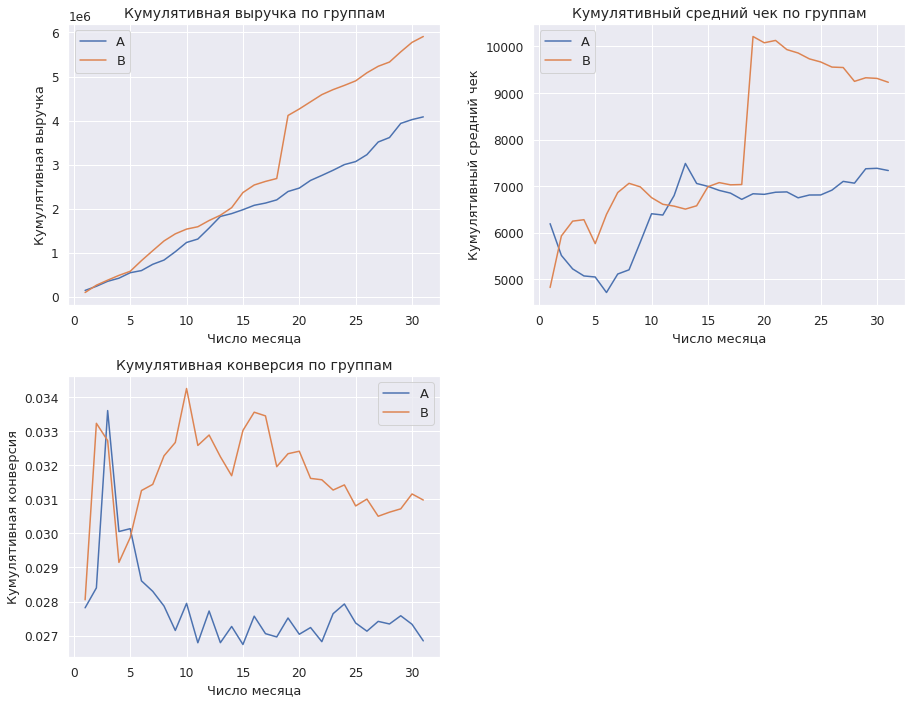

In [23]:
cummulative_plot(data_cummulative)

**Выводы**

1. Кумулятивная выручка группы В незначительно выше, чем в группе А примерно до середины месяца. Кумулятивная выручка группы В с середины месяца начинает расти быстрее чем в группе А (как раз в тот момент, когда средний чек пользователей группы В резко возрастает, что видно на 2 графике).

2. Средний чек двух групп до середины месяца находился примерно на одном уровне. Затем средний чек группы В возрастает с 7000 до 9000-10000, чек группы А фиксируется на значениях в 7000-7500. 

3. Конверсия группы В выше, чем в группе А (3.2% и 2.7% соответственно).

4. На графика кумулятивной выручки и среднего чека видны резкие колебания, это может быть связано с всплесками числа заказов или с появлением очень дорогих заказов в выборке. В следующих пунктах исследования подробнее изучим эти аномалии.

#### Относительное изменение кумулятивного среднего чека и конверсии группы В к группе А

Создадим функцию для построения графиков относительного изменения кумулятивного среднего чека и относительного изменения конверсии группы В к группе А

In [24]:
def rel_diff_plot(df):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 11))
    sns.set(font_scale = 1.1)

    # в таблице графиков — два столбца, одна строка, две ячейки
    ax1 = plt.subplot(2, 2, 1)
    plt.plot(df['day_of_month'], 
             (df['revenueB'] / df['ordersB']) / 
             (df['revenueA'] / df['ordersA']) -1)
    
    ax1.set_xlabel('Число месяца', fontsize = 12)
    ax1.set_ylabel('Относительное изменение среднего чека', fontsize = 12)
    ax1.set_title('Относительное изменение кумулятивного среднего чека В к А', fontsize = 12)
    plt.axhline(y=0, color='black', linestyle='--')
    
    ax2 = plt.subplot(2, 2, 2)
    plt.plot(df['day_of_month'], 
             (df['conversionB']) / 
             (df['conversionA']) -1)
    
    ax2.set_xlabel('Число месяца', fontsize = 12)
    ax2.set_ylabel('Относительное изменение конверсии', fontsize = 12)
    ax2.set_title('Относительное изменение конверсии В к А', fontsize = 12)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=0.1, color='grey', linestyle='--')
    plt.axhline(y=0.2, color='grey', linestyle='--')
    
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.25, 
                        hspace=0.25)
    plt.show()

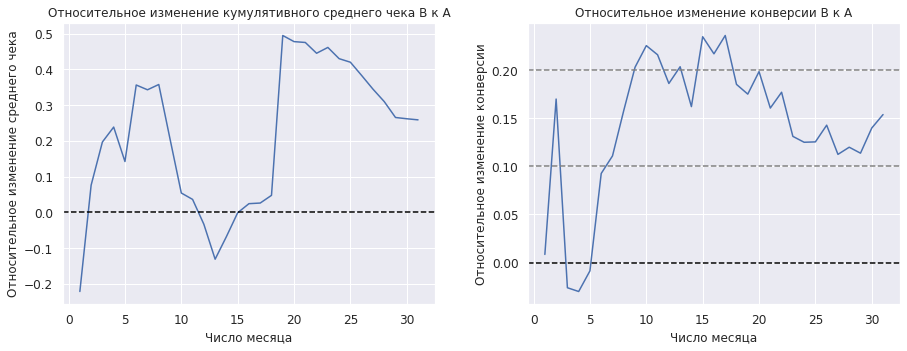

In [25]:
rel_diff_plot(cumulative_groups)

**Выводы**

1. График относительного изменения среднего чека резко менялся в несколько дат (с относительного различия в 0.35 до -0.1 и с -0.1 до 0.5). Похоже, что именно в эти даты и были сделаны аномальные заказы.

2. График относительного изменения конверсии резко изменялся в первых числах (это связано с поступлением новых данных,т.н. проблемой подглядывания). Затем группа В начала стабильно опережать группу А, прирост зафиксировался на уровне 15%.

#### Количество заказов на одного пользователя, распределение стоимости заказов

Функция для построения распределения количества заказов на одного пользователя и стоимости заказов

Для построения графиков из данных будет исключен аномальный заказ в 1,2 млн, чтобы не искажать графики

In [26]:
def orders_plot(df):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 11))
    sns.set(font_scale = 1.1)

    # в таблице графиков — два столбца и одна строка, две ячейки
    ax1 = plt.subplot(2, 2, 1)
    x_values = pd.Series(range(0, len(orders_by_users)))
    sns.scatterplot(data=data_cummulative, x=x_values, y=orders_by_users['orders'])
    
    ax1.set_xlabel('Пользователи', fontsize = 13)
    ax1.set_ylabel('Количество заказов', fontsize = 13)
    ax1.set_title('Количество заказов на одного пользователя', fontsize = 14)
    
    ax2 = plt.subplot(2, 2, 2)
    x_values = pd.Series(range(0, len(orders['revenue'])))
    sns.scatterplot(data=orders, x=x_values, y=orders.query('revenue < 200000')['revenue'])

    
    ax2.set_xlabel('Пользователи', fontsize = 13)
    ax2.set_ylabel('Стоимость заказов', fontsize = 13)
    ax2.set_title('Распределение стоимости заказовов', fontsize = 14)
    
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.25, 
                        hspace=0.25)
    plt.show()

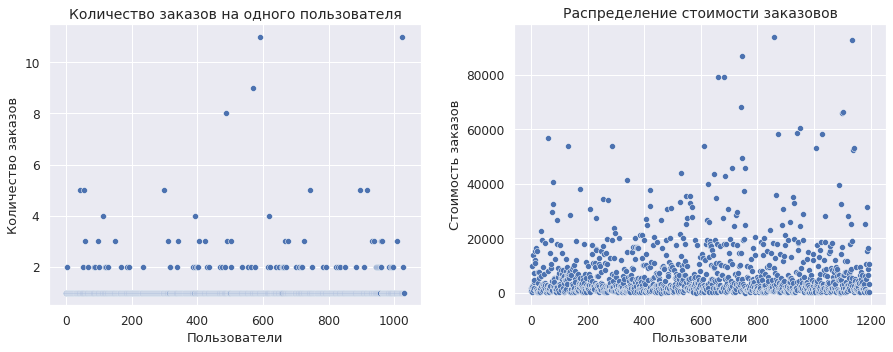

In [27]:
orders_plot(orders)

**Выводы**

1. Большинство пользователей совершают 1 заказ, также есть небольшое количество пользователей, которые совершают 2 или 3 заказа. 

2. Подавляющее большинство заказов стоили менее 20000. Небольшое количество заказов стоили от 20000 до 40000, и совсем незначительное их количество были дороже 40000. 

**Расчёт 95 и 99 перцентилей стоимости заказов и количества заказов на одного пользователя**

In [28]:
orders.head()

,order_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [29]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


In [30]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


In [31]:
max_orders = int(np.percentile(orders_by_users['orders'], [95]))
max_revenue = int(np.percentile(orders['revenue'], [95]))

**Вывод**

* Для количества заказов на одного пользователя 95 и 99 перцентили оказались равными 2 и 4 заказа на пользователя соответственно

* Для стоимости одного заказа 95 и 99 перцентили равны 28000 и 58233 соответственно

* Для удаления аномалий буду использовать 95 перцентили как верхнюю границу для значений количества заказов для одного пользователя и стоимости одного заказа (2 заказа и 28000 рублей соответственно)

### Расчёт статистической значимости различий в конверсии и среднем чеке заказа между группами по "сырым" данным

#### Средний чек заказа

**Гипотезы и уровень значимости**

Нулевая гипотеза - средний чек заказа между группами не отличается

Альтернативная гипотеза - средний чек заказа между группами отличается

Критический уровень значимости - 0.05

Метод проверки гипотез - критерий Манна-Уитни

In [32]:
print('{0:.3f}'.format(
    stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print('{0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean() - 1))

0.729
0.259


**Выводы**

* P-value больше 0.05 - это значит, что статистически значимых отличий в среднем чеке между группами нет
* При этом относительное различие в среднем чеке между группами составляет почти 26%, доход выше с группы В

#### Конверсия

**Гипотезы и уровень значимости**

Нулевая гипотеза - конверсия между группами не отличается

Альтернативная гипотеза - конверсия между группами отличается

Критический уровень значимости - 0.05

Метод проверки гипотез - критерий Манна-Уитни

In [33]:
print('{0:.3f}'.format(stats.mannwhitneyu(sample_A, sample_B)[1]))

print('{0:.3f}'.format((orders_daily_B['orders'].sum() / visitors_daily_B['visitors'].sum()) / 
                       (orders_daily_A['orders'].sum() / visitors_daily_A['visitors'].sum()) - 1))

0.017
0.138


**Выводы**

* P-value меньше 0.05 - это означает, что присутствуют статистические значимые отличия в конверсии между группами
* Относительное различие в конверсии между группами составляет почти 14%

### Расчёт статистической значимости различий в конверсии и среднем чеке заказа между группами по "очищенным" данным

#### Создание очищенных датасетов

Выделим аномальных пользователей с помощью ранее найденных 95 перцентилей для стоимости заказа и количества заказов на одного пользователя

In [34]:
usersWithManyOrders = pd.concat(
                        [orders_by_users_A[orders_by_users_A['orders']>max_orders]['visitor_id'],
                         orders_by_users_B[orders_by_users_B['orders']>max_orders]['visitor_id']],
                         axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > max_revenue]['visitor_id']

abnormalUsers = (pd.concat(
                  [usersWithManyOrders, usersWithExpensiveOrders],axis=0)
                  .drop_duplicates()
                  .sort_values())

Cоздадим переменные `sample_filtered_A` и `sample_filtered_B`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. (Те же `sample_A` и `sample_B`, только отфильтрованные по аномальным клиентам)

In [35]:
sample_filtered_A = pd.concat([
                            orders_by_users_A[np.logical_not(orders_by_users_A['visitor_id'].isin(abnormalUsers))]['orders'], 
                            pd.Series(0, index=np.arange(
                                visitors_daily_A['visitors'].sum() - orders_by_users_A['orders'].count()))], axis=0)

sample_filtered_B = pd.concat([
                            orders_by_users_B[np.logical_not(orders_by_users_B['visitor_id'].isin(abnormalUsers))]['orders'], 
                            pd.Series(0, index=np.arange(
                                visitors_daily_A['visitors'].sum() - orders_by_users_A['orders'].count()))], axis=0)

#### Средний чек заказа

In [36]:
print('{0:.3f}'.format(stats.mannwhitneyu(
          orders[np.logical_and(orders['group']=='A',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
          orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]))
    

print('{0:.3f}'.format(
        orders[np.logical_and(orders['group']=='B',
                              np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() /
        orders[np.logical_and(orders['group']=='A',
                              np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.738
-0.020


**Выводы**

* Значение p-value практически не изменилось - 0.738 (было 0.729), это значение всё так же значительно выше критического уровня значимости в 0.05, статистически значимых отличий в среднем чеке между группами нет
* Относительное в различие в среднем чеке изменилось на 28% (с 26% до -2%), теперь средний чек между группами практически не отличается

#### Конверсия

In [37]:
print('{0:.3f}'.format(stats.mannwhitneyu(sample_filtered_A, sample_filtered_B)[1]))

print('{0:.3f}'.format(sample_filtered_B.mean() / sample_filtered_A.mean() - 1))

0.010
0.179


**Выводы**

* Значение p-value незначительно уменьшилось - с 1,3% до 1%, между группами всё так же присутствует статистические значимые отличия в конверсии
* Относительно различие в конверсии немного увеличилось - с 14% до 18%, у группы В конверсия выше

#### Графики по очищенным данным

Создадим очищенные от аномальных значений датафреймы по аналогии с тем, как создавали датафреймы ранее, и построим графики по очищенным данным

In [38]:
orders_filtered = orders[np.logical_not(orders['visitor_id'].isin(abnormalUsers))]
datesgroupes = orders_filtered[['date', 'group']].drop_duplicates()

orders_agg_filtered = datesgroupes.apply(
    lambda x: orders_filtered[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'order_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}),
     axis=1)\
    .sort_values(by=['date', 'group'])

visitors_agg_filtered = datesgroupes.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] ==x['group'])]
    .agg({'date':'max', 'group':'max', 'visitors':'sum'}),
     axis=1)\
    .sort_values(by=['date', 'group'])

In [39]:
data_cummulative_filtered = orders_agg_filtered.merge(visitors_agg_filtered, on = ['date', 'group'])
data_cummulative_filtered.columns = ['date','group','orders','buyers','revenue','visitors']
data_cummulative_filtered['conversion'] = round(data_cummulative_filtered['orders'] / data_cummulative_filtered['visitors'], 4)
data_cummulative_filtered['day_of_month'] = data_cummulative_filtered['date'].dt.day
data_cummulative_filtered['avg_cheque'] = data_cummulative_filtered['revenue'] / data_cummulative_filtered['orders']
data_cummulative_filtered['conversion'] = data_cummulative_filtered['buyers'] / data_cummulative_filtered['visitors']

In [40]:
cumulative_group_A_filtered = (
    data_cummulative_filtered[data_cummulative_filtered['group'] == 'A'][['day_of_month', 'revenue', 'orders', 'conversion']])
    
cumulative_group_B_filtered = (
    data_cummulative_filtered[data_cummulative_filtered['group'] == 'B'][['day_of_month', 'revenue', 'orders', 'conversion']])

cumulative_groups_filtered = cumulative_group_A_filtered.merge(
    cumulative_group_B_filtered, on='day_of_month', how='left', suffixes=['A','B'])

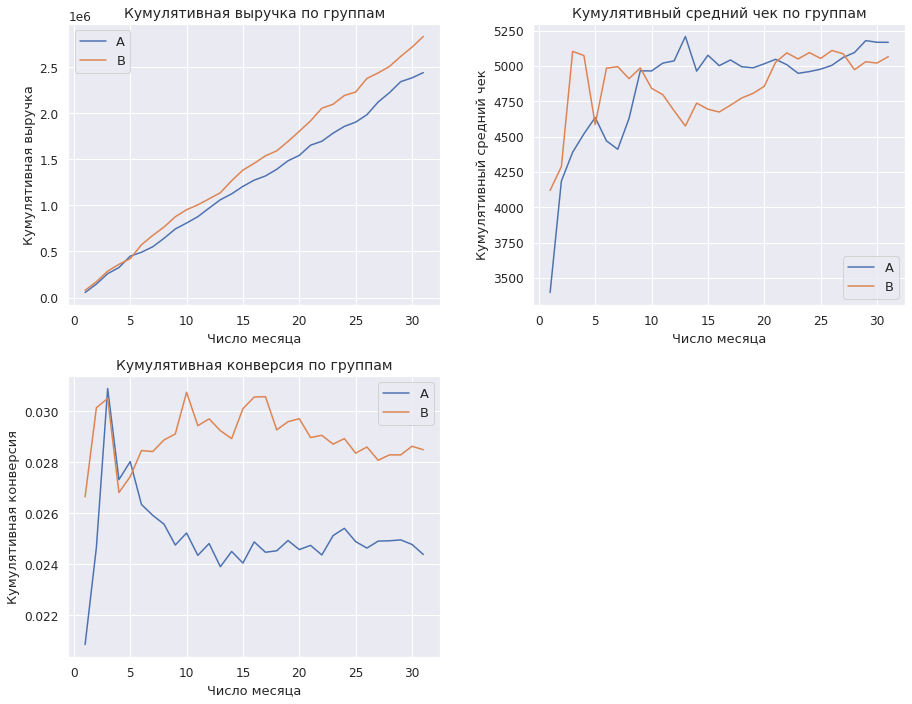

In [41]:
cummulative_plot(data_cummulative_filtered)

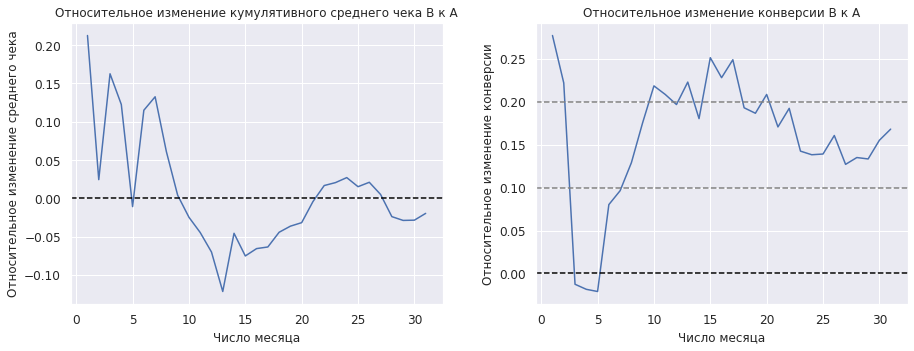

In [42]:
rel_diff_plot(cumulative_groups_filtered)

**Выводы**

По очищенным данным мы можем сделать выводы:
* Кумулятивная выручку с группы В всё так же выше, чем с группы А. Но после очистки данных эта разница снизилась.

* Кумулятивный средний чек выровнялся, между значениями в группах практически нет разницы.

* Конверсия так же выровнялась после очистки данных, группа В сохраняет более высокую конверсию (2.9%), чем группа А (2.4%).

## Принятие решения по результатам теста

На основе проведенного исследования можно принять решение об остановке теста. Между группами не наблюдается значимых отличий по кумулятивной выручке и кумулятивному среднему чеку. Но в то же время наблюдается разница в кумулятивной конверсии - у группы В конверсия выше (относительная разница около 20%). 

Таким образом, можем сделать вывод о победе группы В, так как у нее наблюдается более высокая конверсия в сравнении с группой А.